In [1]:
import numpy as np
import os
import time
from Software.GenuVP import setupGNVP as gnvp
from Software.Xfoil import runXFoil as xf
from Airfoils import airfoil as af

In [2]:
masterDir = os.getcwd()

In [3]:
def ms2mach(ms):
    return ms / 340.29
            
def Re(v, c, n):
    return (v * c) / n

In [4]:
chordMax = 0.18
chordMin = 0.11
umax = 30
umin = 5
ne = 1.56e-5

In [5]:
Machmin = ms2mach(10)
Machmax = ms2mach(30)
Remax = Re(umax, chordMax, ne)
Remin = Re(umin, chordMin, ne)
AoAmax = 15
AoAmin = -6
NoAoA = (AoAmax - AoAmin) * 2 + 1

angles = np.linspace(AoAmin, AoAmax, NoAoA)
Reynolds = np.logspace(np.log10(Remin), np.log10(Remax), 5, base=10)
Mach = np.linspace(Machmax, Machmin, 10)

Reyn = Remax
MACH = Machmax

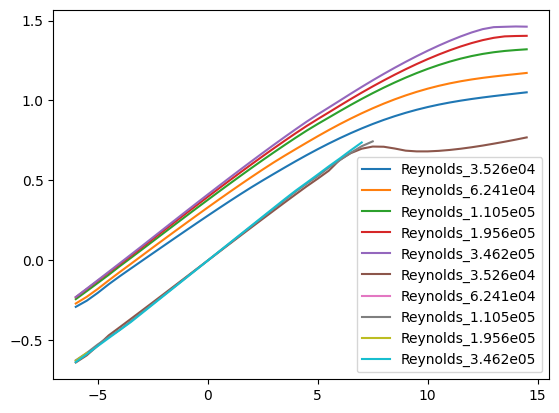

In [6]:
airfoils = ["4415","0008"]

polars = []
for airfoil in airfoils:
    pts = af.saveAirfoil(["s", f'naca{airfoil}', airfoil, 0, 200])
    clcdcmDat = xf.batchRUN(Reynolds, MACH, AoAmin,
                            AoAmax, AoAstep=.5, pts=pts)
    polars.append(clcdcmDat)
xf.plotBatch(polars,Reynolds)

In [8]:
# os.chdir("3D/Plane/")
gnvp.cldFiles(airfoils,polars,Reynolds,angles)

In [7]:
## NOT REALLY
airMovement = {
    'alpha_s': 0.,
    'alpha_e': 0.,
    'beta_s': 0.,
    'beta_e': 0.,
    'phi_s': 0.,
    'phi_e': 0.
}
bodies = []

### Wing

In [8]:
bodies.append({
    'NB': 1,
    "NACA": 4415,
    "name": "Lwing",
    'bld': 'Lwing.bld',
    'cld':  '4415.cld',
    'NNB': 25,
    'NCWB': 25,
    'is_right': False,
    "x_0": 0.,
    "z_0": 0.,
    "y_0": 0.,
    "pitch": 2.8,
    "cone": 0.,
    "wngang": 0.,
    "x_end": 0.,
    "z_end": 0.,
    "y_end": 1.130,
    "Root_chord": 0.159,
    "Tip_chord": 0.072
})
bodies.append({
    'NB': 2,
    "NACA": 4415,
    "name": "Rwing",
    'bld': 'Rwing.bld',
    'cld':  '4415.cld',
    'NNB': 25,
    'NCWB': 25,
    'is_right': True,
    "x_0": 0.,
    "z_0": 0.,
    "y_0": 0.,
    "pitch": 2.8,
    "cone": 0.,
    "wngang": 0.,
    "x_end": 0.,
    "z_end": 0.,
    "y_end": 1.130,
    "Root_chord": 0.159,
    "Tip_chord": 0.072
})

### Elevator

In [9]:
bodies.append({
    'NB': 3,
    "NACA": '0008',
    "name": "Ltail",
    'bld': 'Ltail.bld',
    'cld':  '0008.cld',
    'NNB': 25,
    'NCWB': 25,
    'is_right': False,
    "x_0": 0.54,
    "z_0": 0.,
    "y_0": 0.,
    "pitch": 0.,
    "cone": 0.,
    "wngang": 0.,
    "x_end": 0.,
    "z_end": 0.,
    "y_end": 0.169,
    "Root_chord": 0.130,
    "Tip_chord": 0.03
})
bodies.append({
    'NB': 4,
    "NACA": '0008',
    "name": "Rtail",
    'bld': 'Rtail.bld',
    'cld':  '0008.cld',
    'NNB': 25,
    'NCWB': 25,
    'is_right': True,
    "x_0": 0.54,
    "z_0": 0.,
    "y_0": 0.,
    "pitch": 0.,
    "cone": 0.,
    "wngang": 0.,
    "x_end": 0.,
    "z_end": 0.,
    "y_end": 0.169,
    "Root_chord": 0.130,
    "Tip_chord": 0.03
})

### Rudder

In [10]:
bodies.append({
    'NB': 5,
    "NACA": '0008',
    "name": "rudder",
    'bld': 'rudder.bld',
    'cld':  '0008.cld',
    'NNB': 25,
    'NCWB': 25,
    'is_right': True,
    "x_0": 0.54,
    "z_0": 0.1,
    "y_0": 0.,
    "pitch": 0.,
    "cone": 0.,
    "wngang": 90.,
    "x_end": 0.,
    "z_end": 0.,
    "y_end": 0.169,
    "Root_chord": 0.130,
    "Tip_chord": 0.03
})

In [11]:
angle = 0
params = {
    "nBods": len(bodies),  # len(Surfaces)
    "nBlades": len(airfoils),  # len(NACA)
    "maxiter": 50,
    "timestep": 10,
    "Uinf": [20. * np.cos(angle) , 0.0, 20. * np.sin(angle)],
    "rho": 1.225,
    "visc": 0.0000156,
}

In [12]:
os.chdir(masterDir)
CASE = "3D/Plane/"
gnvp.removeResults(CASE)
gnvp.batchRun(airMovement, bodies, params, airfoils,
              polars, Reynolds, angles, angles, CASE)


rm: cannot remove 'strip*': No such file or directory
rm: cannot remove 'x*': No such file or directory
rm: cannot remove 'refstate*': No such file or directory
forrtl: severe (59): list-directed I/O syntax error, unit 65, file /home/tryfonas/data/Uni/Semester9/Flight_Dynamics/Software/hermes/3D/Plane/0008.cld
Image              PC                Routine            Line        Source             
gnvp               000000000073DAEA  Unknown               Unknown  Unknown
gnvp               000000000043D06C  initgeo_                  442  initia-3.f
gnvp               000000000044FD6D  initgen_                  257  initia-3.f
gnvp               00000000004B40AE  MAIN__                    106  gnvp-3.f
gnvp               00000000004041DD  Unknown               Unknown  Unknown
libc.so.6          00007FD4FA3F6510  Unknown               Unknown  Unknown
libc.so.6          00007FD4FA3F65C9  __libc_start_main     Unknown  Unknown
gnvp               00000000004040F5  Unknown               Un

['0008.cld', '4415.cld', 'dfile.yours', 'gnvp', 'gnvp.out', 'hermes.geo', 'hyb.inf', 'input', 'LOADS_aer.dat', 'Ltail.bld', 'Lwing.bld', 'name.cld', 'res.dat', 'Rtail.bld', 'rudder.bld', 'Rwing.bld']
('.', [], ['0008.cld', '4415.cld', 'dfile.yours', 'gnvp', 'gnvp.out', 'hermes.geo', 'hyb.inf', 'input', 'LOADS_aer.dat', 'Ltail.bld', 'Lwing.bld', 'name.cld', 'res.dat', 'Rtail.bld', 'rudder.bld', 'Rwing.bld'])
Running Angles -6.0
Running Angles -5.5


FileNotFoundError: [Errno 2] No such file or directory: '3D/Plane/'